Решения соревнования "Digit Recognizer" с сайта Kaggle


https://www.kaggle.com/competitions/digit-recognizer/overview/

## 1. Загружаем библиотеки и данные.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from torch import tensor, nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [2]:
train = pd.read_csv('train.csv') # Загружаем тренировочные данные
test = pd.read_csv('test.csv') # Загружаем тестовые данные
sample_sub = pd.read_csv('sample_submission.csv') # Загружаем бланк ответов
train.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train.tail(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41990,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41991,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41992,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41993,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41994,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Первичный анализ данных.

### 2.1. Размерность DataFrame.

In [4]:
train.shape # Размероность тренировочных данных

(42000, 785)

In [5]:
test.shape # Размерность тестовых данных

(28000, 784)

### 2.2 Наличие пропущенных данных.

In [6]:
train.isnull().sum().sum() # Количество пропущенных данных

0

### 2.3. Распределение классов.

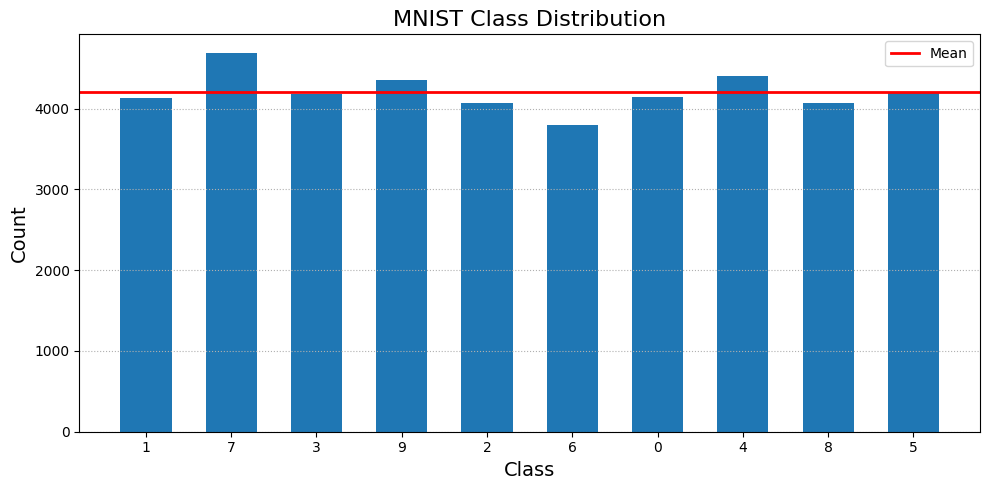

In [8]:
labels = train.label.value_counts().index # Получаем названия классов
counts = train.label.value_counts() # Получаем количество строк по классам

plt.figure(figsize=(10, 5))
plt.bar(labels, counts, width=0.6)
plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Class', fontsize=14) # Добавляем текст на ось X
plt.ylabel('Count', fontsize=14) # Добавляем текст на ось Y
plt.title('MNIST Class Distribution', fontsize=16) # Добавляем заголовок об распределение классов

# Добавляем линию, чтобы показать равномерность распределения признаков
plt.axhline(counts.mean(), color='red', linewidth=2, label='Mean')

plt.legend()
plt.grid(axis='y', linestyle='dotted')

plt.tight_layout()
plt.show()

##### Выводы по второму блоку:

    1. Отсутствуют пропущенные данные.
    2. Признаки для классификации одинаковые для тренировочных и тестовых данных.
    3. Все классы распределены равномерно.

## 3. Предобработка данных.

### 3.1. Разделение данных на метку и изображение.

In [9]:
X = train.drop('label', axis=1) # Картинка
X = X / 255.0
y = train.label # Классы
test = test / 255.0

##### Пояснение:

    Каждый пиксель имеет 1 цветовой канал и кодируется восьмеричной битовой кодировкой.
    Для облегчения обучения разделим на 255 и цвет будет кодироваться от 0 до 1.

### 3.2. Разделение тренировочных данных на обучаемую и валидационную выборку. Перевод из типа DataFrame в Tensor.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.33, random_state=42)
X_train_t =  torch.from_numpy(X_train.values).float()
y_train_t =  torch.from_numpy(y_train.values)
X_val_t =  torch.from_numpy(X_val.values).float()
y_val_t =  torch.from_numpy(y_val.values)

In [11]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

##### Вывод по третьему блоку:

    Данные подготовлены для обучения нейронной сети

## 4. Создание нейронной сети и обучение её.

### 4.1. Выбор устройства для обучения модели.

In [12]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

### 4.2. Объявление структуры нейронной сети.

#####  Структура нейронной сети:

    1. Входные данные сглаживаются благодаря nn.Flatten().
    2. Данные проходят через два линейных слоя преобразований с активацией ReLU.
    3. Данные попадают в последний линейный слой с активацией Softmax.

##### Итог: 
    
    После прохождения данных через нейронную сеть мы на выходе десять узлов, девять из которых с весом 0.


In [13]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,128),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.ReLU(),
    nn.Linear(128,10),
    nn.Softmax()
)

##### В качестве функции потерь используем "nn.CrossEntropyLoss"
##### В качестве оптимизатора используем алгоритм "Adam"

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": val_dataloader}

### 4.3. Процесс обучения нейронной сети

In [15]:
%%time

max_epochs = 200
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = preds.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
                print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8001776830135039
Loader: valid. Accuracy: 0.908946608946609
Epoch: 2
Loader: train. Accuracy: 0.9181236673773987
Loader: valid. Accuracy: 0.9241702741702742
Epoch: 3
Loader: train. Accuracy: 0.9339019189765458
Loader: valid. Accuracy: 0.9264790764790765
Epoch: 4
Loader: train. Accuracy: 0.9430348258706468
Loader: valid. Accuracy: 0.935930735930736
Epoch: 5
Loader: train. Accuracy: 0.9501066098081024
Loader: valid. Accuracy: 0.9414862914862915
Epoch: 6
Loader: train. Accuracy: 0.9551172707889126
Loader: valid. Accuracy: 0.9447330447330448
Epoch: 7
Loader: train. Accuracy: 0.9591329068941009
Loader: valid. Accuracy: 0.9489177489177489
Epoch: 8
Loader: train. Accuracy: 0.962544420753376
Loader: valid. Accuracy: 0.9505772005772006
Epoch: 9
Loader: train. Accuracy: 0.9652452025586354
Loader: valid. Accuracy: 0.9538239538239538
Epoch: 10
Loader: train. Accuracy: 0.9679459843638948
Loader: valid. Accuracy: 0.9523088023088023
Epoch: 11
Loader: train. Accurac

### 4.4. Анализ точность от эпохи обучения нейронной сети.

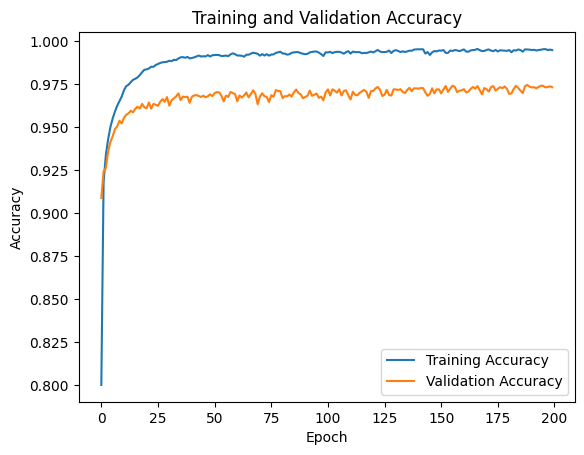

In [16]:
plt.plot(accuracy['train'], label='Training Accuracy')
plt.plot(accuracy['valid'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### Выводы по четвёртому блоку:
    
    1. На тренировочных данных нейронная сеть показывает почти 100%.
    2. На валидационных данных нейронная сеть показывает точность 97%.
    3. Основной рост нейронной сети был до 50 эпохи. После 50 эпохи началась "пила" на всех данных, которая смогла поднять точность на 0.1 % - 1 %.
    4. Модель является быстро обучаемой и обладает хорошей точностью.
    
##### Точность модели на тренировочных данных после 200 эпохи:
    
    99.49182658137882 %
    
##### Точность модели на валидационных данных после 200 эпохи:

    97.33766233766233 %

## 5. Тестирование нейронной сети

### 5.1. Перевод тестовых данных из формата DataFrame в Tensor.

In [17]:
test_t =  torch.from_numpy(test.values).float()

### 5.2. Загрузка тестовых данных в нейронную сеть и получение предсказаний.

In [18]:
with torch.no_grad():
    model.eval() # Переводим модель в состояние предсказаний
    outp = model(test_t) # Получаем ответы по 10 классам
preds = outp.argmax(-1) # Оставляем класс с максимальным значением

In [19]:
preds # Проверяем всё ли правильно получается на выходе

tensor([2, 0, 9,  ..., 3, 9, 2])

### 5.3. Запись предсаказнных данных в файл и последующая проверка их.

In [20]:
output = pd.DataFrame({'ImageId':sample_sub.ImageId, 'Label':preds})
output.to_csv('submission.csv', index=False)

##### Итог:
    
    На тестовых данных модель показала точность в 97.257%, что очень много и является отличным результатом.